In [72]:
import math


class Value:
    def __init__(self, data, children=None, op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children) if children else ()
        self._op = op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self.data + other.data
        out = Value(out, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self.data * other.data
        out = Value(out, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):  # self-other
        return self + (-other)

    def __rsub__(self, other):  # other -self
        return -self + other

    def __neg__(self):  # -self
        return self * -1

    def __truediv__(self, other):
        # x/y == x*y**-1
        return self * other ** -1

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self.data ** other.data
        out = Value(out, (self, other), "pow")

        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        # tanh x = e的2x次方减1 除以 e的2x次方加1
        x = self.data
        v = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(v, (self,), 'tanh')

        def _backward():
            self.grad += (1 - v ** 2) * out.grad

        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # 拓扑排序，只会沿着从左向右一个方向
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [80]:
import random


class Neuron:
    def __init__(self, n_in, nonlin=True):
        self.weight = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.bias = Value(random.uniform(-1, 1))
        self.nonlin = nonlin

    def __call__(self, x):
        # w*x +b
        act = sum(w * x for w, x in zip(self.weight, x)) + self.bias
        out = act.relu() if self.nonlin else act
        return out
    
    def parameters(self):
        return self.weight + [self.bias]


class Layer:
    def __init__(self, n_in, n_out, **kwargs):
        self.neurons = [Neuron(n_in, **kwargs) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i + 1], nonlin=i!=len(n_outs)-1) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [56]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
m = MLP(3, [4, 4, 1])


In [63]:
for k in range(20):
    # forward process
    ypred = [m(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for yout, ygt in zip(ys, ypred)])
    
    # backward process
    # after each update, remember to init the new grad
    # the final loss is changed, so the local derivatives should be changed
    for p in m.parameters():
        p.grad = 0
    loss.backward()
    
    # update parameters
    for p in m.parameters():
        p.data += -0.1 * p.grad 
    
    print(k, loss)

0 Value(0.004681766727090079)
1 Value(0.004617289408884947)
2 Value(0.004554575629617143)
3 Value(0.00449355239529506)
4 Value(0.004434150789942387)
5 Value(0.004376305687710162)
6 Value(0.004319955489551471)
7 Value(0.004265041882007742)
8 Value(0.004211509615933404)
9 Value(0.004159306303230845)
10 Value(0.004108382229879395)
11 Value(0.004058690183729633)
12 Value(0.004010185295697836)
13 Value(0.003962824893139459)
14 Value(0.003916568364308243)
15 Value(0.0038713770329192993)
16 Value(0.003827214041934074)
17 Value(0.0037840442457731964)
18 Value(0.0037418341102413433)
19 Value(0.0037005516195179554)


In [64]:
ypred

[Value(0.9763988755653319),
 Value(-0.9695442214205039),
 Value(-0.9708474460408598),
 Value(0.9630390382469098)]

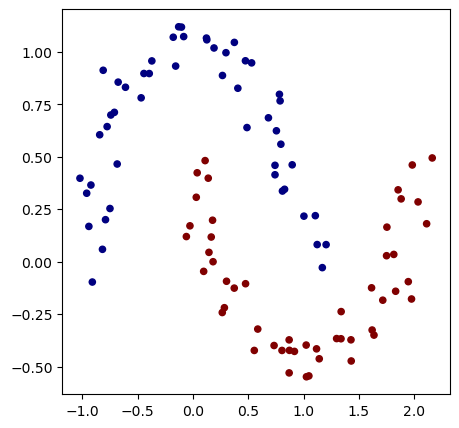

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1337)
random.seed(1337)


# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [81]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [82]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(0.526311195771092) 0.8


In [83]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    for p in model.parameters():
        p.grad = 0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.526311195771092, accuracy 80.0%
step 1 loss 1.3631516810753148, accuracy 50.0%
step 2 loss 2.3536126182334707, accuracy 50.0%
step 3 loss 0.6697498069681572, accuracy 77.0%
step 4 loss 0.4012351412933122, accuracy 83.0%
step 5 loss 0.3744214037972901, accuracy 85.0%
step 6 loss 0.32445304482196097, accuracy 87.0%
step 7 loss 0.3227238430608365, accuracy 86.0%
step 8 loss 0.297801280764128, accuracy 86.0%
step 9 loss 0.3077059994992208, accuracy 86.0%
step 10 loss 0.2752229921810606, accuracy 89.0%
step 11 loss 0.30067110213154724, accuracy 87.0%
step 12 loss 0.24128436888801175, accuracy 89.0%
step 13 loss 0.22725640929061547, accuracy 90.0%
step 14 loss 0.21378660318206996, accuracy 92.0%
step 15 loss 0.2046599942583644, accuracy 92.0%
step 16 loss 0.2326487530724444, accuracy 91.0%
step 17 loss 0.29155877360516097, accuracy 88.0%
step 18 loss 0.22012605478471517, accuracy 92.0%
step 19 loss 0.19076952682273163, accuracy 94.0%
step 20 loss 0.17579428393141278, accuracy 9

(-1.548639298268643, 1.951360701731357)

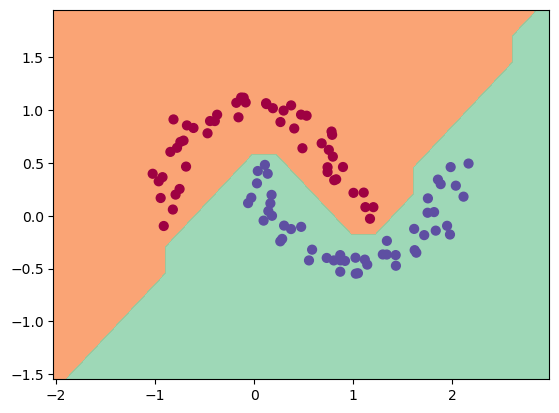

In [84]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())